In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from autoencoder import *
from metrics import *

In [3]:
x, y = load_breast_cancer(return_X_y=True,as_frame=False)
x_df, y_df = load_breast_cancer(return_X_y=True,as_frame=True)
x_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.70, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42)

In [5]:
x_train.shape


(398, 30)

In [8]:
# 1. Calculate min and max for each column
x_min = np.min(x_train, axis=0)
x_max = np.max(x_train, axis=0)

# 2. Calculate the range (handle potential division by zero)
data_range = x_max - x_min
data_range[data_range == 0] = 1.0  # If a column is all the same value, set range to 1

# 3. Apply the formula
x_train_scaled = (x_train - x_min) / data_range

# Verify the results
print(f"New Min: {np.min(x_train_scaled)}") # Should be 0.0
print(f"New Max: {np.max(x_train_scaled)}") # Should be 1.0

New Min: 0.0
New Max: 1.0


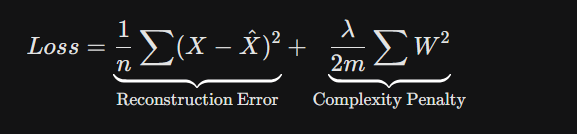

In [6]:
def plot_history(history):
    plt.figure(figsize=(6, 4))

    plt.plot(history['mse_loss'], label='Reconstruction MSE', color='blue', linewidth=2)
    plt.plot(history['total_loss'], label='Total Loss (MSE + L2)', color='orange', linestyle='--')

    plt.title('Training Progress: Total Loss vs. Reconstruction Error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.grid(True, linestyle=':', alpha=0.6) # Adds a subtle grid for easier reading
    plt.legend() # This is the "magic" line that shows the labels

    plt.show()

Epoch 0 - Total Loss: 0.1555 - Reconstruction MSE: 0.092548
Epoch 10 - Total Loss: 0.0867 - Reconstruction MSE: 0.023354
Epoch 20 - Total Loss: 0.0796 - Reconstruction MSE: 0.016162
Epoch 30 - Total Loss: 0.0786 - Reconstruction MSE: 0.015259
Epoch 40 - Total Loss: 0.0783 - Reconstruction MSE: 0.014918
Epoch 50 - Total Loss: 0.0776 - Reconstruction MSE: 0.014266
Epoch 60 - Total Loss: 0.0773 - Reconstruction MSE: 0.013998
Epoch 70 - Total Loss: 0.0772 - Reconstruction MSE: 0.013948
Epoch 80 - Total Loss: 0.0773 - Reconstruction MSE: 0.013984
Epoch 90 - Total Loss: 0.0770 - Reconstruction MSE: 0.013693
Epoch 99 - Total Loss: 0.0772 - Reconstruction MSE: 0.013938


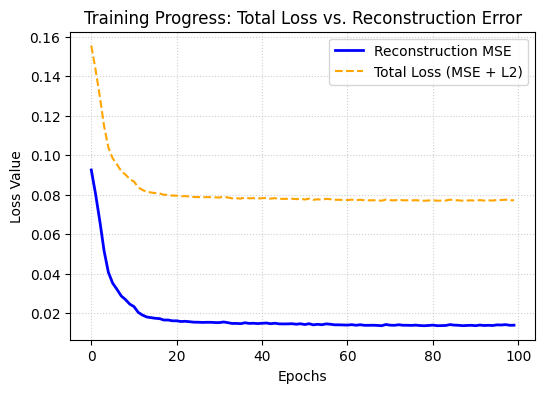

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from autoencoder import *
# 1. Initialize
model = Autoencoder(
    input_dim=x_train.shape[1],
    encoder_dims=[30, 28, 24], # 3 hidden layers for encoder
    bottleneck_dim=5,         # The compressed representation
    decoder_dims=[24, 28, 30], # 3 hidden layers for decoder
    activation='relu',
    learning_rate=0.01,
    l2_lambda=0.01
)

# 2. Train (Fit)
history = model.fit(x_train_scaled, epochs=100, batch_size=32, lr_schedule='cosine')
plot_history(history)

# Experiments

## diffrent number of bottlneck sizes

In [8]:
bottle_neck_sizes = [ 2, 5, 10, 15, 20]
for i in bottle_neck_sizes:
  print(f"Bottleneck size {i}: ")
  autoencoder = Autoencoder(
    input_dim=x_train.shape[1],
    encoder_dims=[30, 28, 24], # 3 hidden layers for encoder
    bottleneck_dim=i,         # The compressed representation
    decoder_dims=[24, 28, 30], # 3 hidden layers for decoder
    activation='relu',
    learning_rate=0.01,
    l2_lambda=0.01
)
  autoencoder.fit(x_train_scaled, verbose=False)

Bottleneck size 2: 
Bottleneck size 5: 
Bottleneck size 10: 
Bottleneck size 15: 
Bottleneck size 20: 


In [9]:
# Transform the scaled data into the compressed representation
# This moves data from (N, input_dim) -> (N, bottleneck_dim)
X_latent = model.encode(x_train_scaled)
print(f"Shape beofre encoding: {x_train_scaled.shape}")
print(f"Shape after encoding: {X_latent.shape}")

Shape beofre encoding: (398, 30)
Shape after encoding: (398, 5)


# Kmeans with autoencoder and PCA

## kmeans with autoencoder


Evaluating Bottleneck size 2...
MSE: 0.013800| WCSS: 2.23 | Silhouette: 0.3795 | db_idx: 0.8448 | ch_idx: 1056.7545882049067

Evaluating Bottleneck size 5...
MSE: 0.014009| WCSS: 5.56 | Silhouette: 0.4085 | db_idx: 0.7560 | ch_idx: 2059.887349242541

Evaluating Bottleneck size 10...
MSE: 0.011457| WCSS: 28.48 | Silhouette: 0.2305 | db_idx: 1.2534 | ch_idx: 208.28240760974447

Evaluating Bottleneck size 15...
MSE: 0.011264| WCSS: 51.01 | Silhouette: 0.2431 | db_idx: 1.1254 | ch_idx: 159.90766032699466

Evaluating Bottleneck size 20...
MSE: 0.012188| WCSS: 61.49 | Silhouette: 0.2561 | db_idx: 1.2922 | ch_idx: 286.17480708009117


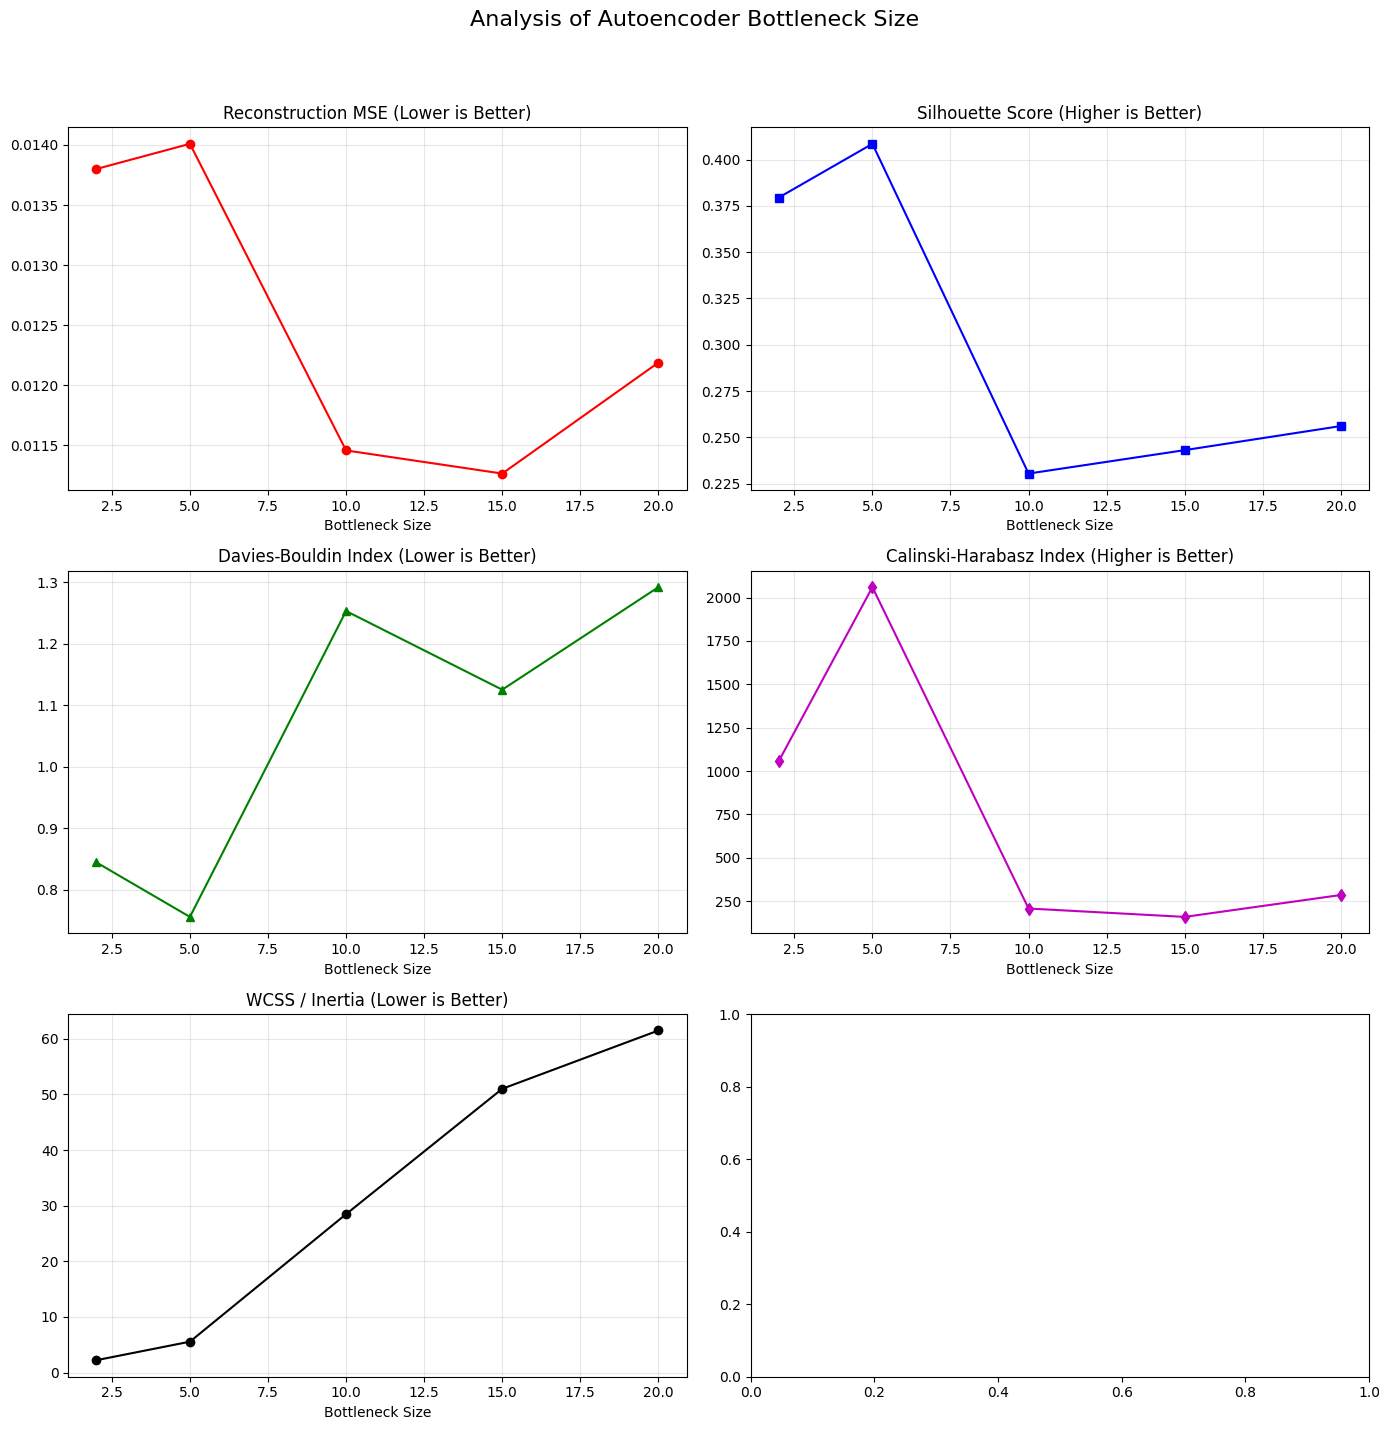

In [ ]:
from autoencoder import *
from metrics import *
from kmeans import *
from sklearn.metrics import adjusted_rand_score # TODO
import matplotlib.pyplot as plt

metrics = ClusteringMetrics()

bottle_neck_sizes = [2, 5, 10, 15, 20]
results = {
    'size': [],
    'mse': [],
    'silhouette': [],
    'db_idx': [],
    'ch_idx': [],
    'wcss': []
}

for i in bottle_neck_sizes:
    print(f"\nEvaluating Bottleneck size {i}...")

    # 1. Initialize and Train
    autoencoder = Autoencoder(x_train_scaled.shape[1], [30, 28, 24], i, [24, 28, 30], 'relu', 0.01, 0.01)
    autoencoder.fit(x_train_scaled, epochs=50, verbose=False)
    # 2. Get Reconstruction Loss (MSE)
    mse = autoencoder.evaluate_mse(x_train_scaled)
    # 3. Get Compressed Features (Bottleneck)
    encoded_features = autoencoder.encode(x_train_scaled)
    # 4. Apply K-Means
    k = 10
    centroids = initialize(encoded_features, k)
    centroids, clusters, _, _ = kmeans(data=encoded_features, centroids=centroids, tolerance=1e-4, max_iterations=100)


    # 5. Calculate Performance Metrics
    sil = metrics.silhouette_score(encoded_features, clusters)
    db_idx = metrics.davies_bouldin_index(encoded_features, clusters)
    ch_idx = metrics.calinski_harabasz_index(encoded_features, clusters)
    wcss = metrics.within_cluster_sum(centroids, encoded_features, clusters)

    # Store results
    results['size'].append(i)
    results['mse'].append(mse)
    results['silhouette'].append(sil) # A higher silhouette Indicates that the samples are far from the neighboring clusters (very well clustered)
    results['db_idx'].append(db_idx) # A lower DBI value indicates better clustering (tight clusters that are far apart)
    results['ch_idx'].append(ch_idx) # Higher values indicate better defined, more separated clusters TODO
    results['wcss'].append(wcss) # A lower value indicates data points are closer to their cluster's centroids TODO

    print(f"MSE: {mse:.6f}| WCSS: {wcss:.2f} | Silhouette: {sil:.4f} | db_idx: {db_idx:.4f} | ch_idx: {ch_idx}")

# --- Visualization ---
# Create a figure with 4 subplots (2x2 grid)
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle('Analysis of Autoencoder Bottleneck Size', fontsize=16)

# 1. Reconstruction MSE (Lower is Better)
axs[0, 0].plot(results['size'], results['mse'], 'r-o')
axs[0, 0].set_title('Reconstruction MSE (Lower is Better)')
axs[0, 0].set_xlabel('Bottleneck Size')
axs[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score (Higher is Better)
axs[0, 1].plot(results['size'], results['silhouette'], 'b-s')
axs[0, 1].set_title('Silhouette Score (Higher is Better)')
axs[0, 1].set_xlabel('Bottleneck Size')
axs[0, 1].grid(True, alpha=0.3)

# 3. Davies-Bouldin Index (Lower is Better)
axs[1, 0].plot(results['size'], results['db_idx'], 'g-^')
axs[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axs[1, 0].set_xlabel('Bottleneck Size')
axs[1, 0].grid(True, alpha=0.3)

# 4. Calinski-Harabasz Index (Higher is Better)
axs[1, 1].plot(results['size'], results['ch_idx'], 'm-d')
axs[1, 1].set_title('Calinski-Harabasz Index (Higher is Better)')
axs[1, 1].set_xlabel('Bottleneck Size')
axs[1, 1].grid(True, alpha=0.3)

# 5. WCSS Plot (Lower is Better)
axs[2, 0].plot(results['size'], results['wcss'], 'k-o')
axs[2, 0].set_title('WCSS / Inertia (Lower is Better)')
axs[2, 0].set_xlabel('Bottleneck Size')
axs[2, 0].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## kmeans with pca

In [ ]:
from pca import *
from metrics import *
from kmeans import *
from sklearn.metrics import adjusted_rand_score # TODO
import matplotlib.pyplot as plt

metrics = ClusteringMetrics()

bottle_neck_sizes = [2, 5, 10, 15, 20]
results = {
    'size': [],
    'mse': [],
    'silhouette': [],
    'db_idx': [],
    'ch_idx': []
}

for i in pca_num:
    print(f"\nEvaluating Bottleneck size {i}...")

    # 1. Initialize and Train PCA #TODO
    autoencoder = Autoencoder(x_train_scaled.shape[1], [30, 28, 24], i, [24, 28, 30], 'relu', 0.01, 0.01)
    autoencoder.fit(x_train_scaled, epochs=50, verbose=False)
    # 2. Get Reconstruction Loss (MSE)
    mse = autoencoder.evaluate_mse(x_train_scaled)
    # 3. Get Compressed Features (Bottleneck)
    encoded_features = autoencoder.encode(x_train_scaled)
                                    #TODO

    # 4. Apply K-Means
    # Assuming 'n_clusters' is the number of classes in your dataset
    k = 10
    centroids = initialize(encoded_features, k)
    _, clusters, _, _ = kmeans(data=encoded_features, centroids=centroids, tolerance=1e-4, max_iterations=100)
    # kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    # cluster_labels = kmeans.fit_predict(encoded_features)

    # 5. Calculate Performance Metrics
    sil = metrics.silhouette_score(encoded_features, clusters)
    db_idx = metrics.davies_bouldin_index(encoded_features, clusters)
    ch_idx = metrics.calinski_harabasz_index(encoded_features, clusters)

    # Store results
    results['size'].append(i)
    results['mse'].append(mse)
    results['silhouette'].append(sil) # a higher silhouette Indicates that the samples are far from the neighboring clusters (very well clustered).
    results['db_idx'].append(db_idx) # A lower DBI value indicates better clustering (tight clusters that are far apart).
    results['ch_idx'].append(ch_idx) # Higher values indicate better defined, more separated clusters

    print(f"MSE: {mse:.6f} | Silhouette: {sil:.4f} | db_idx: {db_idx:.4f} | ch_idx: {ch_idx}")

# --- Visualization ---
# Create a figure with 4 subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Analysis of Autoencoder Bottleneck Size', fontsize=16)

# 1. Reconstruction MSE (Lower is Better)
axs[0, 0].plot(results['size'], results['mse'], 'r-o')
axs[0, 0].set_title('Reconstruction MSE (Lower is Better)')
axs[0, 0].set_xlabel('Bottleneck Size')
axs[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score (Higher is Better)
axs[0, 1].plot(results['size'], results['silhouette'], 'b-s')
axs[0, 1].set_title('Silhouette Score (Higher is Better)')
axs[0, 1].set_xlabel('Bottleneck Size')
axs[0, 1].grid(True, alpha=0.3)

# 3. Davies-Bouldin Index (Lower is Better)
axs[1, 0].plot(results['size'], results['db_idx'], 'g-^')
axs[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axs[1, 0].set_xlabel('Bottleneck Size')
axs[1, 0].grid(True, alpha=0.3)

# 4. Calinski-Harabasz Index (Higher is Better)
axs[1, 1].plot(results['size'], results['ch_idx'], 'm-d')
axs[1, 1].set_title('Calinski-Harabasz Index (Higher is Better)')
axs[1, 1].set_xlabel('Bottleneck Size')
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# GMM with autoencoder and pca

## GMM with autoencoder

In [ ]:
from gmm import *

metrics = GMMMetrics()

bottle_neck_sizes = [2, 5, 10, 15, 20]
results = {
    'size': [],
    'bic': [],
    'aic': [],
    'log': []
}

for i in bottle_neck_sizes:
    print(f"\nEvaluating Bottleneck size {i}...")

    # 1. Initialize and Train
    autoencoder = Autoencoder(x_train_scaled.shape[1], [30, 28, 24], i, [24, 28, 30], 'relu', 0.01, 0.01)
    autoencoder.fit(x_train_scaled, epochs=50, verbose=False)
    # 2. Get Reconstruction Loss (MSE)
    mse = autoencoder.evaluate_mse(x_train_scaled)